In [1]:
import numpy as np
from tqdm import tqdm


%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl

from pycbc.waveform import get_fd_waveform


import sys
sys.path.append("../")
import GSHEWaveform

%load_ext autoreload
%autoreload 2

# 1. Preliminaries


## Range of $\epsilon$ 

<IPython.core.display.Javascript object>


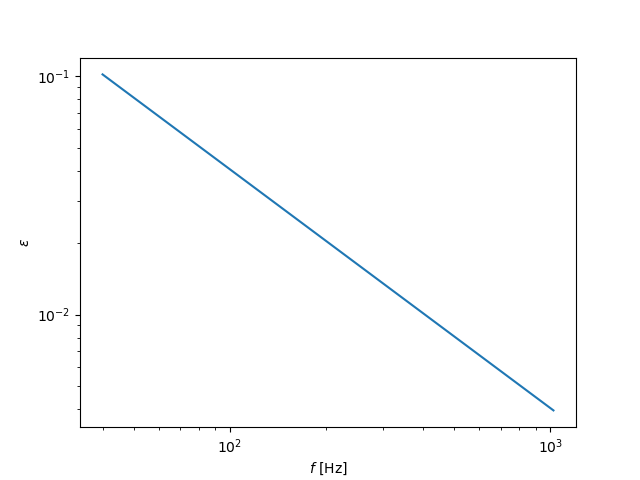

In [2]:
f_min = 40
f_max = 1024
M = 5e4


fs = np.logspace(np.log10(f_min), np.log10(f_max), 1000)

GSHEWaveform.setmplstyle()
plt.figure()
plt.plot(fs, GSHEWaveform.epsilon_from_freq(fs, M))

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$f~[\mathrm{Hz}]$")
plt.ylabel(r"$\epsilon$")
plt.show()

## Mixing Angle

<IPython.core.display.Javascript object>


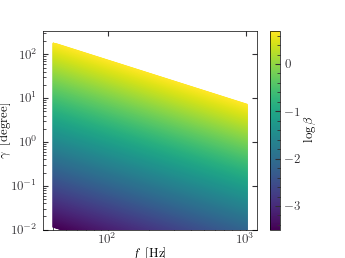

In [4]:


# Range of beta
betas = np.logspace(-3.5, np.log10(5), 1000)
# Freq range for the plot
fs = np.logspace(np.log10(f_min), np.log10(1024))

ys = [None] * betas.size
for i, beta in enumerate(betas):
    delay = GSHEWaveform.time_delay_analytical(fs, M, 2, beta)
    ys[i] = np.rad2deg(np.arccos(np.real(GSHEWaveform.mixing(fs, delay))))
    
segments = [np.column_stack([fs, y]) for y in ys]


GSHEWaveform.setmplstyle("../plot_style.txt")
fig, ax = plt.subplots()
lc = mpl.collections.LineCollection(segments)
lc.set_array(np.log10(betas))
ax.add_collection(lc)
ax.autoscale()
fig.colorbar(lc, label=r"$\log \beta$")


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-2)
ax.set_xlabel(r"$f~[\mathrm{Hz}]$")
ax.set_ylabel(r"$\gamma~\left[\mathrm{degree}\right]$")
plt.savefig("/Users/richard/Downloads/mixing.png", dpi=300)
fig.show()

# 2. Waveform

In [5]:
waveform_params = {"approximant": "IMRPhenomXP", "mass1": 50, "mass2": 35, "spin1z": 0.7,
                   "inclination": 0.9*np.pi}

delta_f = 0.001
left_taper = 20
right_taper = 50

left_window = (f_min - left_taper, f_min)
right_window = (f_max, f_max + right_taper)

fhplus, fhcross = get_fd_waveform(**waveform_params, delta_f=delta_f, f_lower=f_min - left_taper,
                                  f_final=f_max+right_taper)

## Power law mismatch

In [6]:
fhright, fhleft = GSHEWaveform.linear_to_circular(fhplus, fhcross)

maxepsilons = np.logspace(-2, -1, 3)
betas = np.logspace(-2, 1, 50)



mismatches = np.zeros((maxepsilons.size, betas.size))


for i in tqdm(range(maxepsilons.size)):
    Mi = GSHEWaveform.M_from_epsfreq(maxepsilons[i], f_min)
    for j in range(betas.size):
        rdelay = lambda f: GSHEWaveform.time_delay_analytical(f, Mi, 2.0, betas[j])
        mismatches[i, j] = GSHEWaveform.circular_mismatch(fhright, f_min, f_max, rdelay)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.61s/it]


<IPython.core.display.Javascript object>


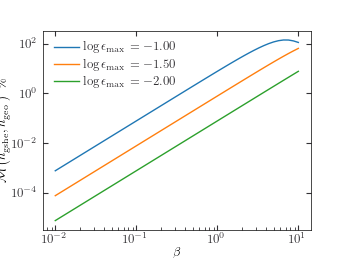

In [48]:
GSHEWaveform.setmplstyle("../plot_style.txt")

plt.figure()

for i in reversed(range(maxepsilons.size,)):
    plt.plot(betas, mismatches[i, ...]*100,
             label=r"$\log \epsilon_{{\max}}={:.2f}$".format(np.log10(maxepsilons[i])))
# plt.axvline(x=2, c="k", ls="--")
    

plt.xlabel(r"$\beta$")
plt.ylabel(r"$\mathcal{M}\left(h_{\rm gshe}^{s=2}, h_{\rm geo}^{s=2}\right)~\%$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig("/Users/richard/Downloads/mismatch.pdf", dpi=450, bbox_inches="tight")

plt.show()

## Circular polarisation analytical waveform plot

<IPython.core.display.Javascript object>


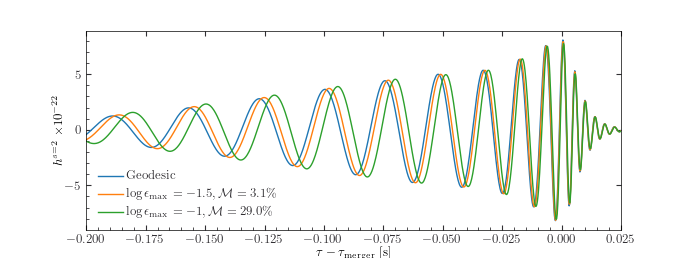

In [47]:
GSHEWaveform.setmplstyle("../plot_style.txt")

fhright, fhleft = GSHEWaveform.linear_to_circular(fhplus, fhcross)
beta = 2


thright = GSHEWaveform.fd_to_td_fiducialshift(fhright, left_window, right_window)



fig, ax = plt.subplots(figsize=(3.45*2, 2.58))
ax.plot(thright.sample_times, thright.data, label="Geodesic")

for logmaxeps in [-1.5, -1]:
    Mi = GSHEWaveform.M_from_epsfreq(10**logmaxeps, f_min)
    rdelay = lambda f: GSHEWaveform.time_delay_analytical(f, Mi, 2.0, beta)
    
    mismatch = GSHEWaveform.circular_mismatch(fhright, f_min, f_max, rdelay)
    
    fhright_gshe = GSHEWaveform.gshe_to_circular(fhright, rdelay)
    thright_gshe = GSHEWaveform.fd_to_td_fiducialshift(fhright_gshe, left_window, right_window)

    ax.plot(thright_gshe.sample_times, thright_gshe.data,
             label=r"$\log \epsilon_{{\max}} = {}, \mathcal{{M}} = {:.1f}\%$"
                    .format(logmaxeps, 100*mismatch))
    
plt.savefig("/Users/richard/Downloads/_tmp.png")

ax.legend(loc="lower left")

ax.set_xlabel(r"$\tau - \tau_{\rm merger}~[\mathrm{s}]$")
ax.set_ylabel(r"$h_{\rm +} [\mathrm{m}]$")
ax.set_xlim(-0.2, 0.025)
GSHEWaveform.ylabel_withoffset(ax, r"$h^{s=2}$")

plt.savefig("/Users/richard/Downloads/circ_waveform.pdf", dpi=450, bbox_inches="tight")
fig.show()

## Circular polarisation from data

In [41]:
# data = GSHEWaveform.read_shooting(13, "../data/", 0.15)

# m = ~np.isnan(data["betas"][:, 0])
# i = np.argsort(np.abs(data["betas"][m, 0] - 2))[1]


# delay = GSHEWaveform.GSHEtoGeodesicDelayInterpolator(
#     data["eps"], data["Xgshe"][m, ...][i, :, :], data["Xgeo"][m, ...][i, :],
#     GSHEWaveform.M_from_epsfreq(0.1, f_min))

Eliminating 193 point due to beta with average 0.9378 loops.


In [ ]:
# from matplotlib.gridspec import GridSpec


# runID = "01"

# Xgeos = np.load("../data/{}Xgeos.npy".format(runID))
# Xgshes = np.load("../data/{}Xgshes.npy".format(runID))
# vary_param = np.load("../data/{}VaryParam.npy".format(runID))
# epsilons = np.load("../data/{}Epsilons.npy".format(runID))

# k = np.abs(vary_param - 0.4*np.pi).argmin()

# Xgeo = Xgeos[k, ...]
# Xgshe = Xgshes[k, ...]

# n = 0
# # rdelay = GSHEWaveform.GSHEtoGeodesicDelayInterpolator(epsilons, Xgshe, Xgeo, n, s=0, M=M)
# # ldelay = GSHEWaveform.GSHEtoGeodesicDelayInterpolator(epsilons, Xgshe, Xgeo, n, s=1, M=M)

# rdelay = lambda f: GSHEWaveform.time_delay_analytical(
#     f, M, GSHEWaveform.coordinate_time_to_seconds(0.3, M), 2.0)
# ldelay = lambda f: GSHEWaveform.time_delay_analytical(
#     f, M, GSHEWaveform.coordinate_time_to_seconds(0.3, M), 2.0)

# default_mplstyle()

# fs = np.linspace(f_min, f_max, 100)
# plt.figure()
# plt.plot(fs, rdelay(fs), label=r"$s=+2$")
# plt.plot(fs, ldelay(fs), label=r"$s=-2$")

# # plt.yscale('log')
# # plt.xscale('log')
# plt.legend()
# plt.show()

# Apply the GSHE corrections to the generated waveform in the frequency domain

# fhplus_gshe, fhcross_gshe = GSHEWaveform.gshe_to_linear(fhplus, fhcross, rdelay, ldelay)

# Inverse Fourier transform to the time domain

# # Plus polarisation
# thplus = GSHEWaveform.fd_to_td_fiducialshift(fhplus, left_window, right_window)
# thplus_gshe = GSHEWaveform.fd_to_td_fiducialshift(fhplus_gshe, left_window, right_window)

# # Cross polarisation
# thcross = GSHEWaveform.fd_to_td_fiducialshift(fhcross, left_window, right_window)
# thcross_gshe = GSHEWaveform.fd_to_td_fiducialshift(fhcross_gshe, left_window, right_window)

# # Plot of the + polarisation state

# default_mplstyle()

# fig, ax = plt.subplots()

# ax.plot(thplus.sample_times, thplus.data, label="Geodesic")
# ax.plot(thplus_gshe.sample_times, thplus_gshe.data, label="GSHE")

# plt.savefig("/Users/richard/Downloads/_tmp.png")

# ax.legend()
# ax.set_xlabel(r"$t - t_{\rm merger} [\mathrm{s}]$")
# ax.set_ylabel(r"$h_{\rm +} [\mathrm{m}]$")
# ax.set_xlim(-0.17, 0.025)
# ylabel_with_offset(ax, r"$h_{\rm +}~[\mathrm{{m}}]$")
# # plt.savefig("/Users/richard/Downloads/hp_example.pdf", )
# fig.show()

# from pycbc.filter.matchedfilter import optimized_match, match



# (1 - optimized_match(fhplus, fhplus_gshe)[0])



# # Strain plot

# Fplus = -0.38
# Fcross = 0.71


# custom_mplstyle()

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3.45*2, 0.75*3.45),
#                          sharex='col',  gridspec_kw={'height_ratios': [1, 0.5]})
# fig.subplots_adjust(hspace=0.0, wspace=0.2)


# for i, kind in enumerate(["heavy_merger", "light_merger"]):
#     data = joblib.load("../data/{}.z".format(kind))
#     thplus = data["thplus"]
#     thcross = data["thcross"]
#     thplus_gshe = data["thplus_gshe"]
#     thcross_gshe = data["thcross_gshe"]
#     strain = GSHEWaveform.waveform_to_strain(thplus, thcross, Fplus, Fcross)
#     strain_gshe = GSHEWaveform.waveform_to_strain(thplus_gshe, thcross_gshe, Fplus, Fcross)

#     axes[0, i].plot(strain.sample_times, strain, label="Geodesic")
#     axes[0, i].plot(strain_gshe.sample_times, strain_gshe, label="GSHE")
#     axes[1, i].plot(strain.sample_times, strain - strain_gshe)




# plt.savefig("/Users/richard/Downloads/_tmp.png")

# axes[1, 0].set_xlim(-0.15, 0.025) 
# axes[1, 1].set_xlim(-0.5, 0.025)


# for i in range(2):
#     axes[1, i].set_xlabel(r"$t - t_{\rm merger} [\mathrm{s}]$")
#     ylabel_with_offset(axes[0, i], r"$h / \mathrm{m}$")
#     ylabel_with_offset(axes[1, i], r"$\Delta h / \mathrm{m}$")
#     axes[0,i].legend()

# plt.savefig("/Users/richard/Downloads/strains.pdf", dpi=300, bbox_inches="tight")
# plt.show()

# fig, ax = plt.subplots()


# data = joblib.load("../data/{}.z".format("heavy_merger"))
# thplus = data["thplus"]
# thcross = data["thcross"]
# thplus_gshe = data["thplus_gshe"]
# thcross_gshe = data["thcross_gshe"]
# strain = GSHEWaveform.waveform_to_strain(thplus, thcross, Fplus, Fcross)
# strain_gshe = GSHEWaveform.waveform_to_strain(thplus_gshe, thcross_gshe, Fplus, Fcross)

# ax.plot(strain.sample_times, strain, label="Geodesic")
# ax.plot(strain_gshe.sample_times, strain_gshe, label="GSHE")

# ax.set_xlim(-0.16, 0.04) 

# plt.savefig("/Users/richard/Downloads/_tmp.png")

# ax.set_xlabel(r"$t - t_{\rm merger} [\mathrm{s}]$")
# ylabel_with_offset(ax, r"$h$")


# ax.legend()


# plt.savefig("/Users/richard/Downloads/strain.pdf", bbox_inches="tight")
# fig.show()